
# Left ventricle bullseye

This example demonstrates how to create the 17 segment model for the left
ventricle recommended by the American Heart Association (AHA).

.. redirect-from:: /gallery/specialty_plots/leftventricle_bulleye

See also the :doc:`/gallery/pie_and_polar_charts/nested_pie` example.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import os

def bullseye_plot(ax, data, seg_bold=None, cmap="viridis", norm=None):
    """
    Bullseye representation for the left ventricle.

    Parameters
    ----------
    ax : axes
    data : list[float]
        The intensity values for each of the 17 segments.
    seg_bold : list[int], optional
        A list with the segments to highlight.
    cmap : colormap, default: "viridis"
        Colormap for the data.
    norm : Normalize or None, optional
        Normalizer for the data.

    Notes
    -----
    This function creates the 17 segment model for the left ventricle according
    to the American Heart Association (AHA) [1]_

    References
    ----------
    .. [1] M. D. Cerqueira, N. J. Weissman, V. Dilsizian, A. K. Jacobs,
        S. Kaul, W. K. Laskey, D. J. Pennell, J. A. Rumberger, T. Ryan,
        and M. S. Verani, "Standardized myocardial segmentation and
        nomenclature for tomographic imaging of the heart",
        Circulation, vol. 105, no. 4, pp. 539-542, 2002.
    """

    data = np.ravel(data)
    if seg_bold is None:
        seg_bold = []
    if norm is None:
        norm = mpl.colors.Normalize(vmin=data.min(), vmax=data.max())

    r = np.linspace(0.2, 1, 4)

    ax.set(ylim=[0, 1], xticklabels=[], yticklabels=[])
    ax.grid(False)  # Remove grid

    # Fill segments 1-6, 7-12, 13-16.
    for start, stop, r_in, r_out in [
            (0, 6, r[2], r[3]),
            (6, 12, r[1], r[2]),
            (12, 16, r[0], r[1]),
            (16, 17, 0, r[0]),
    ]:
        n = stop - start
        dtheta = 2*np.pi / n
        ax.bar(np.arange(n) * dtheta + np.pi/2, r_out - r_in, dtheta, r_in,
               color=cmap(norm(data[start:stop])))

    # Now, draw the segment borders.  In order for the outer bold borders not
    # to be covered by inner segments, the borders are all drawn separately
    # after the segments have all been filled.  We also disable clipping, which
    # would otherwise affect the outermost segment edges.
    # Draw edges of segments 1-6, 7-12, 13-16.
    for start, stop, r_in, r_out in [
            (0, 6, r[2], r[3]),
            (6, 12, r[1], r[2]),
            (12, 16, r[0], r[1]),
    ]:
        n = stop - start
        dtheta = 2*np.pi / n
        ax.bar(np.arange(n) * dtheta + np.pi/2, r_out - r_in, dtheta, r_in,
               clip_on=False, color="none", edgecolor="k", linewidth=[
                   4 if i + 1 in seg_bold else 2 for i in range(start, stop)])
    # Draw edge of segment 17 -- here; the edge needs to be drawn differently,
    # using plot().
    ax.plot(np.linspace(0, 2*np.pi), np.linspace(r[0], r[0]), "k",
            linewidth=(4 if 17 in seg_bold else 2))

In [2]:
from easydict import EasyDict

os.chdir(f"{os.environ['HOME']}/01_repos")
from CardiacMotionGWAS.helpers import EnsembleResults, fetch_loci_mapping
from CardiacMotion.utils.run_helpers import Run, compute_thickness_per_aha
from paths import Paths

lvwt_results = EnsembleResults(root_dir=f"{Paths.Data.gwas_results}/LVWT")
snp_info = lvwt_results.region_assocs_df.loc[lvwt_results.region_assocs_df.groupby("SNP").P.idxmin()]
snp_info = snp_info.iloc[:,[2,4,3,1,4,5,6]]
# assocs_for_relevant_regions = lvwt_results.region_assocs_df[lvwt_results.region_assocs_df.region.apply(lambda region: region in relevant_regions)]
# lead_snp_df = assocs_for_raelevant_regions.loc[assocs_for_relevant_regions.groupby("region").P.idxmin()]
# lead_snp_df = lead_snp_df.sort_values(["CHR", "BP"])

snp_info_dict = EasyDict(snp_info.set_index("SNP").to_dict())

2024-03-04 01:17:47 - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
2024-03-04 01:17:47 - INFO - Failed to load library ( 'libGLU.so.0' ): libGLU.so.0: cannot open shared object file: No such file or directory
2024-03-04 01:17:47 - INFO - Failed to load library ( 'libglut.so.0' ): libglut.so.0: cannot open shared object file: No such file or directory
2024-03-04 01:17:48 - INFO - Reading runs from cached file /home/user/01_repos/CardiacMotionGWAS/results/run_info.csv.
2024-03-04 01:18:07 - INFO - Found 226 runs. Cached file will be overwritten.
2024-03-04 01:18:09 - INFO - Found 102 files under the folder /mnt/data/workshop/workshop-user1/output/GWAS/LVWT/summaries
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 212.64it/s]
2024-03-04 01:18:09 - INFO - Collected GWAS summary data for 102 phenotypes.
2024

In [3]:
pvals_df = pd.read_csv("/home/user/01_repos/CardiacMotionGWAS/results/LVWT_pvals.csv")
pvals_df = pvals_df.set_index(["magnitude", "rel_or_abs", "phase", "segment"])
log_pvals = -np.log10(pvals_df)

log_pvals_thickness_ed = log_pvals.transpose()["thickness", "absolute", "ED"]
log_pvals_thickness_ed = log_pvals_thickness_ed.drop("avg", axis=1)

log_pvals_thickness_es = log_pvals.transpose()["thickness", "absolute", "ES"]
log_pvals_thickness_es = log_pvals_thickness_es.drop("avg", axis=1)
log_pvals_thickness_es['aha01'] = log_pvals_thickness_es.apply(lambda row: 0.67*row.aha06+0.33*row.aha03, axis=1)
log_pvals_thickness_es['aha02'] = log_pvals_thickness_es.apply(lambda row: 0.33*row.aha06+0.67*row.aha03, axis=1)
log_pvals_thickness_es['aha08'] = log_pvals_thickness_es.apply(lambda row: 0.5*row.aha07+0.5*row.aha09, axis=1)
log_pvals_thickness_es['aha11'] = log_pvals_thickness_es.apply(lambda row: 0.5*row.aha10+0.5*row.aha12, axis=1)
log_pvals_thickness_es = log_pvals_thickness_es[sorted(log_pvals_thickness_es.columns)]

log_pvals_thickness_rel_ed = log_pvals.transpose()["thickness", "relative", "ED"]
log_pvals_thickness_rel_ed = log_pvals_thickness_rel_ed.drop("avg", axis=1)

log_pvals_thickness_rel_es = log_pvals.transpose()["thickness", "relative", "ES"]
log_pvals_thickness_rel_es = log_pvals_thickness_rel_es.drop("avg", axis=1)

log_pvals_thickening_abs = log_pvals.transpose()["thickening", "absolute"]
# log_pvals_thickening_abs = log_pvals_thickening_abs.drop("avg", axis=1)

log_pvals_thickening_rel = log_pvals.transpose()["thickening", "relative"]
# log_pvals_thickening_rel = log_pvals_thickening_rel.drop("avg", axis=1)

/tmp/ipykernel_14748/4027896264.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  log_pvals_thickness_ed = log_pvals.transpose()["thickness", "absolute", "ED"]
/tmp/ipykernel_14748/4027896264.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  log_pvals_thickness_es = log_pvals.transpose()["thickness", "absolute", "ES"]
/tmp/ipykernel_14748/4027896264.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  log_pvals_thickness_rel_ed = log_pvals.transpose()["thickness", "relative", "ED"]
/tmp/ipykernel_14748/4027896264.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  log_pvals_thickness_rel_es = log_pvals.transpose()["thickness", "relative", "ES"]
/tmp/ipykernel_14748/4027896264.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  log_pvals_thickening_abs = log_pvals.transpose()["thickening", "absolute"]
/tmp/ipykernel_14748/4027896264.py:25: Per

segment
aha01    1.71609
aha02    1.03402
aha03    0.37201
aha04    0.54704
aha05    1.79020
aha06    2.37810
aha07    2.66820
aha08    2.35910
aha09    2.05000
aha10    2.30390
aha11    2.00950
aha12    1.71510
aha13    5.47860
aha14    6.25990
aha15    5.91810
aha16    4.41200
aha17    9.52790
Name: rs145528066, dtype: float64


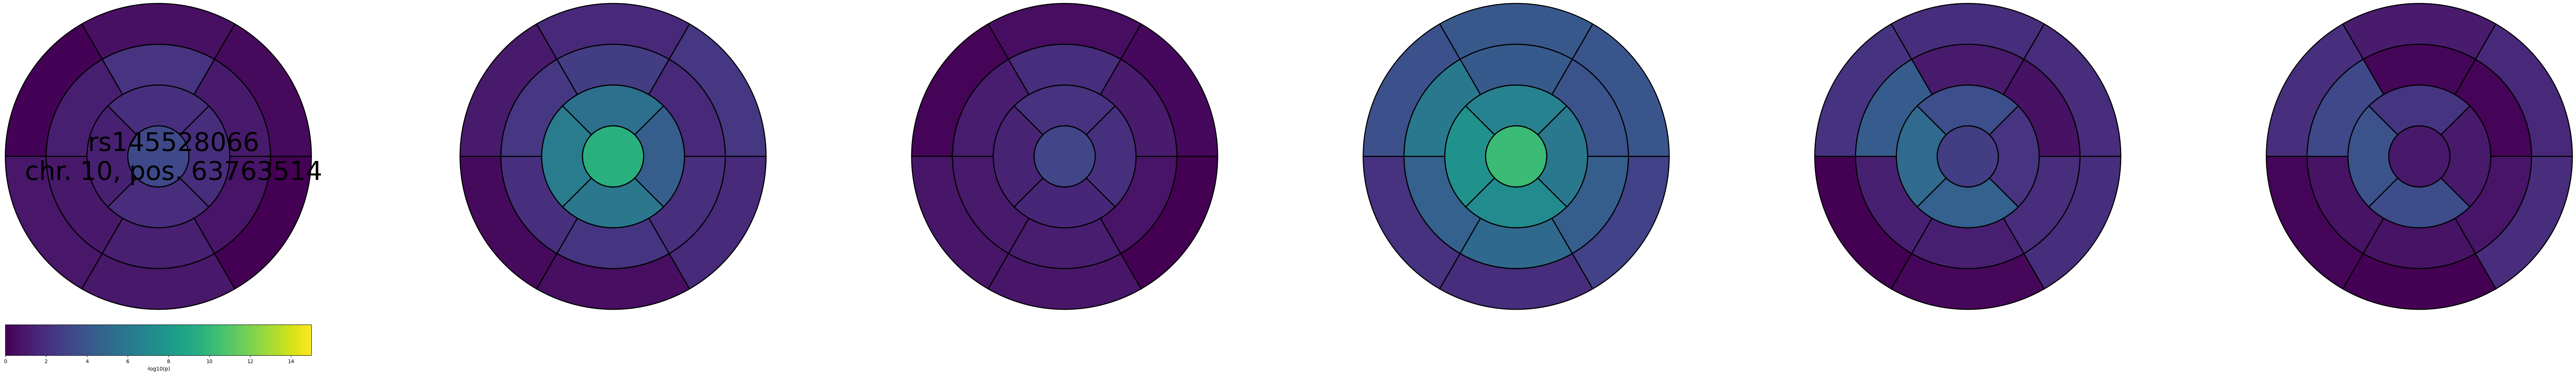

In [4]:
# Make a figure and axes with dimensions as desired.

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=15)

for i, (snp, row) in enumerate(list(log_pvals_thickness_ed.iterrows())[0:1]):
    
    fig = plt.figure(figsize=(70, 10), layout="constrained")
    fig.get_layout_engine().set(wspace=.3, w_pad=.2)
    fig.canvas.manager.set_window_title('Left Ventricle Bulls Eyes (AHA)')
    
    axs = fig.subplots(1, 6, subplot_kw=dict(projection='polar'))
    axs = [axs]
    
    snp = log_pvals_thickness_ed.index[i]
    data_ed = log_pvals_thickness_ed.iloc[i]
    data_es = log_pvals_thickness_es.iloc[i]
    data_rel_ed = log_pvals_thickness_rel_ed.iloc[i]
    data_rel_es = log_pvals_thickness_rel_es.iloc[i]
    data_thickening_abs = log_pvals_thickening_abs.iloc[i]
    data_thickening_rel = log_pvals_thickening_rel.iloc[i]
    
    axs[0][0].text(-0.1, 0.1, f"{snp}\nchr. {snp_info_dict.CHR[snp]}, pos. {snp_info_dict.BP[snp]}", fontsize=50, va='center', ha='center', rotation=0)
    
    # fig.colorbar(
    #   mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    #   cax=axs[0][0].inset_axes([0, -.15, 1, .1]),
    #   orientation='horizontal', label='-log10(p)'
    # )
    # print(data_es)
    # Create the 17 segment model
    bullseye_plot(axs[0][0], data_ed, cmap=cmap, norm=norm)
    bullseye_plot(axs[0][1], data_es, cmap=cmap, norm=norm)
    bullseye_plot(axs[0][2], data_rel_ed, cmap=cmap, norm=norm)
    bullseye_plot(axs[0][3], data_rel_es, cmap=cmap, norm=norm)
    bullseye_plot(axs[0][4], data_thickening_abs, cmap=cmap, norm=norm)
    bullseye_plot(axs[0][5], data_thickening_rel, cmap=cmap, norm=norm)
    
    
    filename = f'CardiacMotionGWAS/bullseye/chr{str(snp_info_dict.CHR[snp]).zfill(2)}_{str(snp_info_dict.BP[snp]).zfill(9)}_{snp}.eps'
    plt.savefig(filename, format='eps')

    plt.show()